In [1]:
# the datasets contain hand drawn images of numbers throught 0-9
# Each number is 28*28 = 784 pixels
# the darkness of each pixel is denotd by an integer through 0-255 
# darker means higher number

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline 

In [2]:
train=pd.read_csv(r"C:\Users\aaparajit\Desktop\Nerdville Horror\Py_KERAS_MNIST_CNN\train.csv")
test=pd.read_csv(r"C:\Users\aaparajit\Desktop\Nerdville Horror\Py_KERAS_MNIST_CNN\test.csv")

In [3]:
print(train.shape)
ntrain=train.shape[0]

(42000, 785)


In [4]:
print(test.shape)
ntest=test.shape[0]

(28000, 784)


In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# we will train the CNN on the training dataset and then predict labels on test dataset
ytrain=train['label']
xtrain=train.drop('label',axis=1)

In [7]:
# Since the images are in square form, so Dim^2=784
dim=int(sqrt(xtrain.shape[1]))

In [8]:
ytrain.head(3)

0    1
1    0
2    1
Name: label, dtype: int64

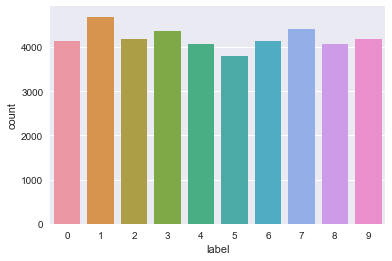

In [9]:
sns.set(context='notebook',palette='deep',style='darkgrid')
sns.countplot(ytrain)

In [10]:
val_class=ytrain.value_counts()
print(val_class.sort_values(ascending=True))
# digit 1 occurs mosr frequently and digit 5 occurs least

5    3795
8    4063
4    4072
0    4132
6    4137
2    4177
9    4188
3    4351
7    4401
1    4684
Name: label, dtype: int64


In [11]:
cls_mean=np.mean(val_class)
cls_std=np.std(val_class,ddof=1)

In [12]:
print("The mean amount of elements per class is", cls_mean)
print("The standard deviation in the element per class distribution is", cls_std)

The mean amount of elements per class is 4200.0
The standard deviation in the element per class distribution is 237.08929400825616


In [13]:
# 68 % of data should be within cls_std standard deviations from mean
if cls_std>cls_mean*(0.6827/2):
    print("Sigma is high")

In [14]:
# checking for missing values
def check_nan(df):
    print(df.isnull().any().describe())
    print("Missing values present" if df.isnull().any().any() else "No Missing values present")
    if df.isnull().any().any():
        print(df.isnull().sum(axis=0))
    print()

In [15]:
check_nan(xtrain)

count       784
unique        1
top       False
freq        784
dtype: object
No Missing values present



In [16]:
check_nan(test)

count       784
unique        1
top       False
freq        784
dtype: object
No Missing values present



In [17]:
# visualizing first nine images
# reshaping the train dataset to plot it 
xtrain_viz=xtrain.values.reshape(ntrain,dim,dim)

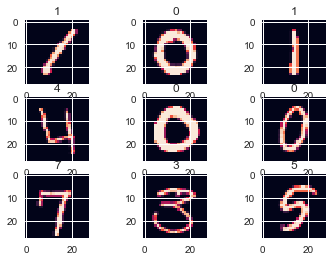

In [18]:
for i in range(0,9):
    plt.subplot(330+(i+1))
    plt.imshow(xtrain_viz[i])
    plt.title(ytrain[i])

In [19]:
# Data Normalization
# since there are 255 pixels bringing values i range of 0 to 1
xtrain=xtrain/255.0
test=test/255.0

In [20]:
# defining a function to reshape
def df_reshape(df):
    print("The previous dimensions were:",df.shape)
    df=df.values.reshape(-1,dim,dim,1)
    print("After reshaping the dimensions change to:",df.shape)
    return df

In [21]:
xtrain=df_reshape(xtrain)
test=df_reshape(test)

The previous dimensions were: (42000, 784)
After reshaping the dimensions change to: (42000, 28, 28, 1)
The previous dimensions were: (28000, 784)
After reshaping the dimensions change to: (28000, 28, 28, 1)


In [22]:
# for the NN to correctly identify labels we will need to convert them to one-hot encoding
from keras.utils.np_utils import to_categorical

C:\Users\aaparajit\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
nclasses=ytrain.max()-ytrain.min()+1

In [24]:
nclasses

10

In [25]:
ytrain=to_categorical(ytrain,num_classes=nclasses)

In [26]:
ytrain.shape

(42000, 10)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
seed=2
np.random.seed(seed)
split_pct=0.2

In [29]:
xtrain,xval,ytrain,yval=train_test_split(xtrain,ytrain,test_size=split_pct,random_state=seed,stratify=ytrain)
#dataset now divides as - 
# train - xtrain(images) and ytrain(labels) = 80 %
# validation - xval(images) and yval(labels)= 20 % 

In [30]:
print(xtrain.shape,ytrain.shape,xval.shape,yval.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10)


In [31]:
# Defining CNN architecture
from keras import backend as K
# architecture
from keras.models import Sequential
from keras.layers import Dense,Dropout,Lambda,Flatten,BatchNormalization,Conv2D,MaxPool2D,AvgPool2D
# Optimizer, Data generator and cost
from keras.optimizers import adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [32]:
# Building the CNN
model=Sequential()
dim=28
nclasses=10
model.add(Conv2D(filters=32,kernel_size=(5,5), padding='same',activation='relu',input_shape=(dim,dim,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5), padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.23))
model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.23))
model.add(Flatten())
model.add(Dense(120,activation='relu'))
model.add(Dense(84,activation='relu'))
model.add(Dense(nclasses,activation='softmax'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [34]:
# compiling the model 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
# setting up model learning rate reduction
# basically when the LR doesnt change for 3 epochs (patience) it decreases by the specified factor
# and this will keep happening till we reach the specified min_lr value 
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.6,min_lr=0.00001)

In [36]:
epochs=15
batch_size=64

In [37]:
# Data augmentation
datagen= ImageDataGenerator(featurewise_center=False,samplewise_center=False,featurewise_std_normalization=False,
                           samplewise_std_normalization=False,zca_whitening=False,
                           rotation_range=30,zoom_range=0.1,width_shift_range=0.1,
                           height_shift_range=0.1,horizontal_flip=False,vertical_flip=False)

In [38]:
datagen.fit(xtrain)

In [39]:
# Model fitting 
# fit_generator used instead of fit because we have augmented the data
history = model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(xval,yval),
                              verbose=1, 
                              steps_per_epoch=xtrain.shape[0] // batch_size, 
                              callbacks=[lr_reduction])

Epoch 1/15
525/525 [==============================] - 237s 451ms/step - loss: 0.4000 - acc: 0.8717 - val_loss: 0.0660 - val_acc: 0.9771
Epoch 2/15
525/525 [==============================] - 245s 467ms/step - loss: 0.1239 - acc: 0.9615 - val_loss: 0.0612 - val_acc: 0.9815
Epoch 3/15
525/525 [==============================] - 240s 458ms/step - loss: 0.0896 - acc: 0.9724 - val_loss: 0.0511 - val_acc: 0.9836
Epoch 4/15
525/525 [==============================] - 267s 508ms/step - loss: 0.0749 - acc: 0.9780 - val_loss: 0.0301 - val_acc: 0.9898
Epoch 5/15
525/525 [==============================] - 260s 495ms/step - loss: 0.0668 - acc: 0.9799 - val_loss: 0.0319 - val_acc: 0.9896
Epoch 6/15
525/525 [==============================] - 271s 516ms/step - loss: 0.0622 - acc: 0.9810 - val_loss: 0.0285 - val_acc: 0.9918
Epoch 7/15
525/525 [==============================] - 267s 508ms/step - loss: 0.0550 - acc: 0.9828 - val_loss: 0.0295 - val_acc: 0.9912
Epoch 8/15
525/525 [============================

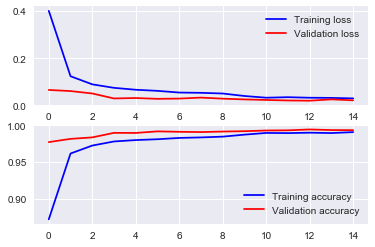

In [40]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

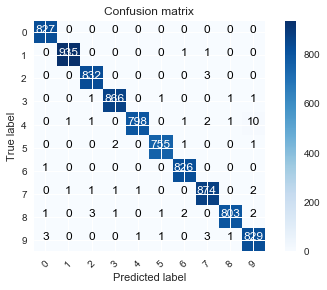

In [41]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

ypred_onehot = model.predict(xval)
ypred = np.argmax(ypred_onehot,axis=1)
ytrue = np.argmax(yval,axis=1)
confusion_mtx = confusion_matrix(ytrue, ypred)
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

In [49]:
predictions = model.predict_classes(test, verbose=1)

28000/28000 [==============================] - 73s 3ms/step


In [ ]:
# End! 